# animatpylab

This notebook is a proof of concept for learning animats simulated with _position-based dynamics physics_ (PBD).

The PBD [[1]](#bibliography) is implemented with edge and triangle constraints with simple collisions with the ground (including friction). 
For more advanced PBD, I encourage you to visit my [PBD2D project][pbd2d]. 
Simulation data is stored and processed with the `numpy` package.

Animats are based on the paper [[2]](#bibliography). 
The implementation of the animats is introduced by constraint values oscillation. 
Each point influences the corresponding edge's rest length by an additional oscillator $\Omega_i$:

$$
\Omega_i = A_i \sin(\omega_i t + \phi_i)
$$

As a result, each edge's rest length $\ell_0$ is modified in time in the following way:

$$
\ell(t) = (1 + \Omega_i + \Omega_j) \cdot \ell(0)
$$

To teach animats how to move, the objective function $J(A, \omega, \phi)$ was minimized via the parameter $\{A_i, \omega_i, \phi_i\}$:

$$
\min_{A, \omega, \phi} J(A, \omega, \phi) = \min_{\{A_i, \omega_i, \phi_i\}} -\frac{1}{N}\sum_{i=1}^N \left[p_i(t)-p_i(0)\right] \cdot \hat x
$$

In other words the optimization procedure should maximize the center of mass translation in $\hat x$ direction.


[pbd2d]: https://github.com/andywiecko/PBD2D

## Install

In [ ]:
%pip install matplotlib==3.6.3
%pip install numpy==1.24.0
%pip install scikit-learn==1.2.1
%pip install scikit-optimize==0.9.0
%pip install scipy==1.10.1

## Dependencies

In [1]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from skopt import gp_minimize
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from sklearn.cluster import KMeans

## PBD implementation

Below one can find the implementation of the PBD routines.
In the following functions, the standard physics notation was used:

- `p` positions;
- `q` previous positions;
- `e` edges;
- `t` triangles;
- `rho` mass density;
- `v` velocities;
- `a` aceleration;
- `dt` delta time;
- `mu` friction coeficient;
- `l0` rest lengths;
- `k` stiffness;
- `w` weights (inverse masses);
- `a0` rest areas.

In [2]:
def generate_edge_constraints(p, e):
    return np.sqrt(((p[e[:, 0]] - p[e[:, 1]])**2).sum(axis=1))

def generate_triangle_constraints(p, t):
    a, b, c = p[t[:, 0]], p[t[:, 1]], p[t[:, 2]]
    return np.cross(b - a, c - a)

def generate_oscilators(bounds, size):
    a = np.random.uniform(low=bounds[0][0], high=bounds[0][1], size=(size,1))
    omega = np.random.uniform(low=bounds[1][0], high=bounds[1][1], size=(size,1))
    phi = np.random.uniform(low=bounds[2][0], high=bounds[2][1], size=(size,1))
    return np.hstack((a, omega, phi))

def generate_weights(t, p, rho):
    w = np.zeros(len(p))
    for i in range(len(t)):
        t0, t1, t2 = t[i, 0], t[i, 1], t[i, 2]
        p0, p1, p2 = p[t0], p[t1], p[t2]

        p01 = p1 - p0
        p02 = p2 - p0
        a = np.cross(p01, p02)
        w0 = 6. / rho / np.abs(a)
        w[t0] += w0
        w[t1] += w0
        w[t2] += w0
    return w

def step_start(p, q, v, a, dt):
    v += a * dt
    q[:] = p[:]
    p += v * dt

def collide_with_floor(p, q, mu):
    id = p[:, 1] < 0
    fn = p[:, 1][id]
    p[:, 1][id] = 0

    dx = p[:, 0][id] - q[:, 0][id]
    s = np.sign(dx)
    dx = np.minimum(np.abs(dx), mu * np.abs(fn)) * s
    p[:, 0][id] -= dx

def edge_constraint(p, w, e, l0, k):
    for i in range(len(e)):
        e0, e1 = e[i, 0], e[i, 1]
        p0, p1, w0, w1 = p[e0], p[e1], w[e0], w[e1]
        n = p1 - p0
        l = np.linalg.norm(n)
        if l <= 1e-9:
            continue
        n = -n / l
        lam = -(l - l0[i]) / (w0 + w1)
        dx = k * lam * n
        p[e0] += w0 * dx
        p[e1] -= w1 * dx

def triangle_constraint(p, w, t, a0, k):
    for i in range(len(t)):
        t0, t1, t2 = t[i, 0], t[i, 1], t[i, 2]
        p0, p1, p2, w0, w1, w2 = p[t0], p[t1], p[t2], w[t0], w[t1], w[t2]
        
        p01 = p1 - p0
        p02 = p2 - p0
        p12 = p2 - p1
        lam = w0 * np.dot(p12, p12) + w1 * np.dot(p02, p02) + w2 * np.dot(p01, p01)
        if lam < 1e-7:
            continue

        lam = k / lam
        a = np.cross(p01, p02)
        if np.abs(a) < 1e-7:
            continue

        dx = lam * (a - a0[i])
        ccw = np.array([[0, -1], [1, 0]])
        p[t0] -= dx * w0 * ccw @ p12
        p[t1] -= dx * w1 * ccw @ -p02
        p[t2] -= dx * w2 * ccw @ p01

def step_end(p, q, v, dt):
    v[:] = (p[:] - q[:]) / dt

## System implementation

`System` class implements classic PBD step algorithm. 
It supports `yaml` initialization, see `box.yaml` example:

```yaml
positions:
  [
    [0., 0],
    [1, 0.2],
    [2, 0.2],
    [3, 0],
    [0, 1],
    [1, 1],
    [2, 1],
    [3, 1],
  ]

edges:
  [
    [0, 1], [1, 2], [2, 3],
    [4, 5], [5, 6], [6, 7],
    [0, 4], [1, 5], [2, 6], [3, 7],
    [0, 5], [1, 6], [2, 7],
  ]

triangles:
  [
    [0, 4, 5], [0, 5, 1], [1, 5, 6],
    [1, 6, 2], [2, 6, 7], [2, 7, 3],
  ]
```

In [3]:
class System:
    def __init__(self):
        self.steps = 8
        self.dt = 1. / 60 / self.steps
        self.g = np.array([0, -100])
        self.tau = 1.
        self.t = 0.
        self.T = 10.
        self.edge_stiffness = 1.
        self.triangle_stiffness = 1.
        self.mu = 10.

    def initialize(self, data_path):
        with open(data_path) as f:
            data = yaml.safe_load(f)
            self.positions = np.array(data['positions'])
            self.edges = np.array(data['edges'])
            self.triangles = np.array(data['triangles'])
            self.weights = generate_weights(self.triangles, self.positions, rho=1.)
            self.previous_positions = np.zeros(self.positions.shape)
            self.velocities = np.zeros(self.positions.shape)
            self.constraint_e = generate_edge_constraints(self.positions, self.edges)
            self.constraint_t = generate_triangle_constraints(self.positions, self.triangles)
            self.oscilators = np.zeros((len(self.positions), 3))

    def copy_from(self, other):
        self.steps = other.steps
        self.dt = other.dt
        self.g = other.g
        self.tau = other.tau
        self.t = other.t
        self.T = other.T
        self.edge_stiffness = other.edge_stiffness
        self.triangle_stiffness = other.triangle_stiffness
        self.mu = other.mu

        self.positions = other.positions.copy()
        self.edges = other.edges.copy()
        self.triangles = other.triangles.copy()
        self.weights = other.weights.copy()
        self.previous_positions = other.previous_positions.copy()
        self.velocities = other.velocities.copy()
        self.constraint_e = other.constraint_e.copy()
        self.constraint_t = other.constraint_t.copy()
        self.oscilators = other.oscilators.copy()

    def step(self):
        step_start(self.positions, self.previous_positions, self.velocities, self.g, self.dt)
        gensin = lambda o, e, t: o[e, 0] * np.sin(o[e, 1] * t + o[e, 2])
        factor = lambda o, e, t: gensin(o, e[:, 0], t) + gensin(o, e[:, 1], t)
        ramp = min(1.-(self.tau-self.t) / self.tau, 1)
        f = 1 + ramp * factor(self.oscilators, self.edges, self.t)
        edge_constraint(self.positions, self.weights, self.edges, f * self.constraint_e, k=self.edge_stiffness)
        triangle_constraint(self.positions, self.weights, self.triangles, self.constraint_t, k=self.triangle_stiffness)
        collide_with_floor(self.positions, self.previous_positions, mu=self.mu)
        step_end(self.positions, self.previous_positions, self.velocities, self.dt)  

    def simulate(self, x=None):
        self.t = 0
        if x is not None:
            x.append(self.positions.copy())
            while self.t < self.T:
                self.step()
                self.t += self.dt
                x.append(self.positions.copy())
        else:
            while self.t < self.T:
                self.step()
                self.t += self.dt

    def mean_position(self): 
        return self.positions.mean(axis=0)

## Box

In [4]:
def black_box_function(x):
    system.copy_from(system_raw)
    system.oscilators = np.array(x).reshape(system.oscilators.shape)

    mu0 = system.positions.mean(axis=0)[0]
    system.simulate()
    mu = system.positions.mean(axis=0)[0]
    dist = mu0 - mu

    global i, sol, best_oscilators
    if sol < -dist:
        best_oscilators = system.oscilators.copy()

    sol = max(sol, -dist)
    print(i, -dist, sol)
    i += 1
    
    return dist

def update(i, x, e):
    ax.clear()
    ax.set_aspect('equal')
    ax.set_xlim((-1, +30))
    ax.set_ylim((-0.1, 3))
    ax.scatter(x[i][:, 0], x[i][:, 1], color='blue')
    ax.set_title(f'$i={i}$')
    for ei in e:
        p = x[i][ei]
        ax.plot(p[:, 0], p[:, 1], color='blue')

In [48]:
system_raw = System()
system_raw.initialize('box.yaml')
system = System()
bounds = [(0.0, 0.15), (0.0, 20.0), (-np.pi, np.pi)]
best_oscilators = generate_oscilators(bounds, len(system_raw.oscilators))

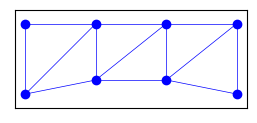

In [54]:
p = system_raw.positions
fig, ax = plt.subplots(figsize=(3,2))
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_ylim(-0.2,1.2)
ax.set_yticks([])
for ei in system_raw.edges:
        pi = p[ei]
        ax.plot(pi[:, 0], pi[:, 1], linewidth=.5, color='blue')
ax.scatter(p[:, 0], p[:, 1], zorder=100, color='blue')
plt.show()

In [ ]:
np.random.seed(42)
s = system_raw.oscilators.shape

system_raw.edge_stiffness = 0.5
system_raw.triangle_stiffness = 1.
i, sol = 0, 0
for _ in range(100):
    o = generate_oscilators(bounds, len(system_raw.oscilators))
    black_box_function(o.flatten())

In [ ]:
system.copy_from(system_raw)
system.oscilators = best_oscilators.copy()
mu0 = system.mean_position()[0]
system.simulate(x := [])
mu = system.mean_position()[0]
print(mu - mu0)

fig, ax = plt.subplots(figsize=(10, 2))
ani = FuncAnimation(fig, update, frames=len(x[::16]), interval=100, fargs=(x[::16], system_raw.edges,))
ani.save('img/box-gen-1.gif')
plt.close()

In [ ]:
sol, i = 0, 0
result = minimize(black_box_function, 
  x0=best_oscilators.flatten(), 
  method='L-BFGS-B', 
  bounds=bounds * len(system_raw.oscilators),
  #options={ 
  #  'maxiter' : 2,
  #  'maxfun' : 5,
  #  'maxls' : 5,
  #}
)

In [ ]:
system.copy_from(system_raw)
system.oscilators = best_oscilators.copy()
mu0 = system.mean_position()[0]
system.simulate(x := [])
mu = system.mean_position()[0]
print(mu - mu0)

fig, ax = plt.subplots(figsize=(10, 2))
ani = FuncAnimation(fig, update, frames=len(x[::16]), interval=100, fargs=(x[::16], system_raw.edges,))
ani.save('img/box-gen-2.gif')
plt.close()

In [ ]:
sol, i = 0, 0
result = gp_minimize(
    func=black_box_function, 
    dimensions=bounds * len(system_raw.oscilators),
    n_calls=1_00,
    x0=list(best_oscilators.flatten()),
    n_jobs=8
)

In [ ]:
sol, i = 0, 0
result = dual_annealing(
    func=black_box_function, 
    bounds=bounds * len(system_raw.oscilators),
    maxiter=10,
    maxfun=100,
    x0=best_oscilators.flatten()
)

In [ ]:
i, sol = 0, 0
result = basinhopping(
    func=black_box_function,
    x0=best_oscilators.flatten(),
    minimizer_kwargs= { "method": "L-BFGS-B", "bounds": bounds * len(system_raw.oscilators)  },
    niter=100
)

In [ ]:
system.copy_from(system_raw)
system.oscilators = best_oscilators.copy()
mu0 = system.mean_position()[0]
system.simulate(x := [])
mu = system.mean_position()[0]
print(mu - mu0)

fig, ax = plt.subplots(figsize=(10,2))
ani = FuncAnimation(fig, update, frames=len(x[::16]), interval=100, fargs=(x[::16], system_raw.edges,))
ani.save('img/box-gen-3.gif')
plt.close()

### Results

#### Generation 1

![box-gen-1](img/box-gen-1.gif)

#### Generation 2

![box-gen-2](img/box-gen-2.gif)

#### Generation 3

![box-gen-3](img/box-gen-3.gif)

## Bunny

In [55]:
bounds = [(0.0, 0.20), (0.0, 20.0), (-np.pi, np.pi)]
system_raw = System()
system_raw.initialize('bunny.yaml')
system = System()

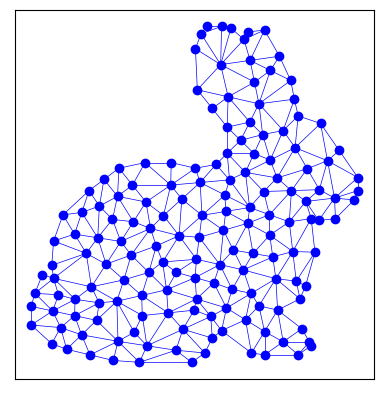

In [47]:
p = system_raw.positions
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
for ei in system_raw.edges:
        pi = p[ei]
        ax.plot(pi[:, 0], pi[:, 1], linewidth=.5, color='blue')
ax.scatter(p[:, 0], p[:, 1], zorder=100, color='blue')
plt.show()

In [58]:
best_oscilators = np.load("data/bunny-gen-3.npy")

In [ ]:
np.random.seed(42)

i, sol = 0, 0
for _ in range(10):
    o = generate_oscilators(bounds, len(system_raw.oscilators))
    black_box_function(o.flatten())

In [ ]:
sol, i = 0, 0
result = gp_minimize(
    func=black_box_function, 
    dimensions=bounds * len(system_raw.oscilators),
    n_calls=100,
    x0=list(best_oscilators.flatten()),
    n_jobs=8)

In [ ]:
sol, i = 0, 0
result = dual_annealing(
    func=black_box_function, 
    bounds=bounds * len(system_raw.oscilators),
    maxiter=10,
    maxfun=100,
    x0=best_oscilators.flatten()
)

In [ ]:
sol, i = 0, 0
result = differential_evolution(
    func=black_box_function, 
    bounds=bounds * len(system_raw.oscilators), 
    maxiter=16 * 5,
    x0=best_oscilators.flatten(),
    workers=16
)

In [ ]:
sol, i = 0, 0
result = minimize(black_box_function, 
  x0=best_oscilators.flatten(), 
  method='L-BFGS-B', 
  bounds=bounds * len(system_raw.oscilators),
  options={ 
    'maxiter' : 2,
    'maxfun' : 5,
    'maxls' : 5,
  }
)

In [14]:
np.save('data/bunny-gen-3', best_oscilators) 

In [20]:
def update_bunny(i, x, e):
    ax.clear()
    ax.set_aspect('equal')
    ax.set_xlim((-1, +10))
    ax.set_ylim((-0.1, 3))
    ax.set_title(f'$i={i}$')
    for ei in e:
        p = x[i][ei]
        ax.plot(p[:, 0], p[:, 1], color='blue', linewidth=0.5)

for i in [1, 2, 3]:
    system.copy_from(system_raw)
    system.oscilators = np.load(f"data/bunny-gen-{i}.npy")
    mu0 = system.mean_position()[0]
    system.simulate(x := [])
    mu = system.mean_position()[0]
    print(f"sim complete! ({mu-mu0})")

    fig, ax = plt.subplots(figsize=(10, 3))
    ani = FuncAnimation(fig, update_bunny, frames=len(x[::16]), interval=100, fargs=(x[::16], system_raw.edges,))
    ani.save(f'img/bunny-gen-{i}.gif')
    plt.close()

sim complete! (0.6391610906728422)
sim complete! (2.296809725000455)
sim complete! (2.440255332728552)


### Results

#### Generation 1

![bunny-gen-1](img/bunny-gen-1.gif)

#### Generation 2

![bunny-gen-2](img/bunny-gen-2.gif)

#### Generation 3

![bunny-gen-3](img/bunny-gen-3.gif)

## Clustering

Reduction of the parameter space size can help with solution to converge. 
Test specimen points were splited into clusters. 
Each point which belongs to cluster, inherits parameters from cluster.

In [21]:
bounds = [(0.0, 0.20), (0.0, 20.0), (-np.pi, np.pi)]

system_raw = System()
system_raw.initialize('bunny.yaml')
system = System()

best_oscilators = np.load('data/cluster-bunny-gen-2.npy.npy')
best_cluster_oscilators = np.load('data/cluster-bunny-gen-2-clusters.npy.npy')

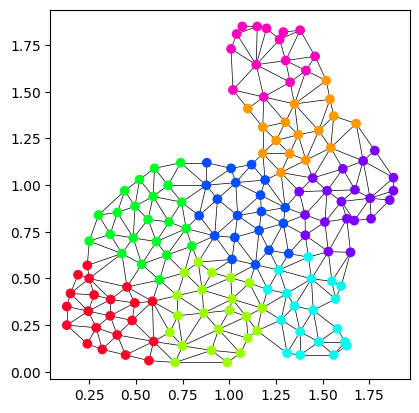

In [23]:
clusters_count = 8

kmeans = KMeans(n_clusters=clusters_count, random_state=0, n_init="auto").fit(system_raw.positions)

p = system_raw.positions
fig, ax = plt.subplots()
ax.set_aspect('equal')
for ei in system_raw.edges:
        pi = p[ei]
        ax.plot(pi[:, 0], pi[:, 1], color='black', linewidth=.5)
ax.scatter(p[:, 0], p[:, 1], c=kmeans.labels_, cmap='gist_rainbow', zorder=100)
plt.show()

In [24]:
clusters = {}
for i in range(clusters_count):
    clusters[i] = np.where(kmeans.labels_ == i)[0].copy()

In [25]:
def black_box_function_clusters(x):
    system.copy_from(system_raw)

    clusters_oscilators = np.array(x).reshape((clusters_count, 3))
    oscilators = np.zeros(system_raw.oscilators.shape)
    for j in range(clusters_count):
        oscilators[clusters[j]] = clusters_oscilators[j]
    system.oscilators = oscilators

    mu0 = system.positions.mean(axis=0)[0]
    system.simulate()
    mu = system.positions.mean(axis=0)[0]
    dist = mu0 - mu

    global i, sol, best_oscilators, best_cluster_oscilators
    if sol < -dist:
        best_oscilators = system.oscilators.copy()
        best_cluster_oscilators = clusters_oscilators.copy()

    sol = max(sol, -dist)
    print(i, -dist, sol)
    i += 1
    
    return dist

In [ ]:
np.random.seed(42)

i, sol = 0, 0
for _ in range(10):
    o = generate_oscilators(bounds, clusters_count)
    black_box_function_clusters(o.flatten())

In [ ]:
sol, i = 0, 0
result = minimize(black_box_function_clusters, 
  x0=best_cluster_oscilators.flatten(), 
  method='L-BFGS-B', 
  bounds=bounds * clusters_count,
  options={ 
    'maxiter' : 2,
    'maxfun' : 5,
    'maxls' : 5,
  }
)

In [ ]:
sol, i = 0, 0
result = gp_minimize(
    func=black_box_function_clusters, 
    dimensions=bounds * clusters_count,
    n_calls=1_00,
    x0=list(best_cluster_oscilators.flatten()),
    n_jobs=8)

In [37]:
np.save('data/cluster-bunny-gen-2', best_oscilators) 
np.save('data/cluster-bunny-gen-2-clusters', best_cluster_oscilators) 

In [ ]:
def update_bunny(i, x, e):
    ax.clear()
    ax.set_aspect('equal')
    ax.set_xlim((-1, +30))
    ax.set_ylim((-0.1, 3))
    ax.set_title(f'$i={i}$')
    for ei in e:
        p = x[i][ei]
        ax.plot(p[:, 0], p[:, 1], color='blue', linewidth=0.5)

for i in [1, 2, 3]:
    system.copy_from(system_raw)
    system.oscilators = np.load(f"data/cluster-bunny-gen-{i}.npy")
    mu0 = system.mean_position()[0]
    system.simulate(x := [])
    mu = system.mean_position()[0]
    print(f"sim complete! ({mu-mu0})")

    fig, ax = plt.subplots(figsize=(10, 2))
    ani = FuncAnimation(fig, update_bunny, frames=len(x[::16]), interval=100, fargs=(x[::16], system_raw.edges,))
    ani.save(f'img/cluster-bunny-gen-{i}.gif')
    plt.close()

### Results

#### Generation 1

![cluster-bunny-gen-1](img/cluster-bunny-gen-1.gif)

#### Generation 2

![cluster-bunny-gen-2](img/cluster-bunny-gen-2.gif)

#### Generation 3

![cluster-bunny-gen-3](img/cluster-bunny-gen-3.gif)

### Conclusions

Animats simulated by PBD physics can be learnt to move, however, the process can be computionally expensive.
Please note that the obtained result for bunny movement does not look naturally. 
Locomotion can be tunned by increasing the PBD accuracy (delta time).
In our simulation bunny behaves like "jelly". 
With smaller delta time/higher simulation steps the bunny can be more stiff. 

## Bibliography

[1] Müller, Matthias, et al. "Position based dynamics." Journal of Visual Communication and Image Representation 18.2 (2007): 109-118.

[2] Joachimczak, Michał, et al. "Bringing drawings to life: evolving distributed controllers for hand-drawn soft-bodied robots." signs 8.9 (2015): 10-11.